Workflow:

1) Remove columns with high missingness

2) Log transform continious variables due to right skew and convert all continious variables to z-scores and perform univariate analysis 

3) Perform Mann Whitney to see which features differ in their rank sum between fraud and non fraud 

4) Plot KDE plots with 0s and 1s overlayed to see if there are thresholds that can make for good heuristics for the snorkel package

In [ ]:
import pandas as pd
import numpy as np
import os

RAW_DIR = 'data/raw'
PROCESSED_DIR = 'data/processed'

In [ ]:
master_df = pd.read_csv(os.path.join(PROCESSED_DIR, "customer_transaction_features_master.csv"))

print("Master DF head, and shape")
display(master_df.head())
display(master_df.shape)


Master DF head, and shape


C:\Users\22156\AppData\Local\Temp\ipykernel_14616\3472439609.py:4: DtypeWarning: Columns (4,5,6,8,10,12,15,16,21) have mixed types. Specify dtype option on import or set low_memory=False.
  master_df = pd.read_csv("data/processed/customer_transaction_features_master.csv")


,customer_id,country,province,city,gender,marital_status,occupation_code,income,birth_date,onboard_date,...,channel_debit_volume,cash_ratio,wire_ratio,abm_cash_deposit_volume,abm_cash_withdrawal_volume,median_hold_time_funds,incoming_to_outgoing_time_mean,txn_to_sales_ratio,txn_volume_vs_income,txn_volume_vs_occupation_median
0,SYNID0100000167,CA,ON,TORONTO,NaN,Married,10019,48886.0,1/30/1972,9/20/2011,...,1698.68,0.000000,0.0,0.00,0.00,177.681944,173.744167,NaN,0.236520,0.294872
1,SYNID0100000431,CA,NaN,other,FEMALE,Married,72310,NaN,3/20/1988,6/4/2018,...,13850.78,0.188780,0.0,1450.25,2541.38,17.395972,22.751477,NaN,NaN,0.611887
2,SYNID0100000485,CA,ON,BRAMPTON,FEMALE,Widowed,RETIRED,19998.0,5/2/1935,7/12/1997,...,3688.32,0.081895,0.0,786.74,0.00,43.822222,70.768687,NaN,0.480380,0.330523
3,SYNID0100000539,CA,NaN,other,MALE,Widowed,RETIRED,39417.0,11/4/1944,5/14/1985,...,10132.79,0.000000,0.0,0.00,0.00,2.027222,9.773889,NaN,0.261252,0.354301
4,SYNID0100000932,CA,ON,TORONTO,FEMALE,Married,RETIRED,34182.0,9/14/1963,7/9/2012,...,29489.69,0.012337,0.0,0.00,2150.97,3.717083,7.228990,NaN,5.100535,5.998503


(61410, 122)

In [ ]:
#### Merge with labels ####
labels = pd.read_csv(os.path.join(RAW_DIR, "labels.csv"))
master_df_withLabels = master_df.merge(labels, on="customer_id",how="outer")

print("df with labels")
display(master_df_withLabels.shape)
display(master_df_withLabels.head())

df with labels


(61410, 123)

,customer_id,country,province,city,gender,marital_status,occupation_code,income,birth_date,onboard_date,...,cash_ratio,wire_ratio,abm_cash_deposit_volume,abm_cash_withdrawal_volume,median_hold_time_funds,incoming_to_outgoing_time_mean,txn_to_sales_ratio,txn_volume_vs_income,txn_volume_vs_occupation_median,label_y
0,SYNID0100000167,CA,ON,TORONTO,NaN,Married,10019,48886.0,1/30/1972,9/20/2011,...,0.000000,0.0,0.00,0.00,177.681944,173.744167,NaN,0.236520,0.294872,NaN
1,SYNID0100000431,CA,NaN,other,FEMALE,Married,72310,NaN,3/20/1988,6/4/2018,...,0.188780,0.0,1450.25,2541.38,17.395972,22.751477,NaN,NaN,0.611887,NaN
2,SYNID0100000485,CA,ON,BRAMPTON,FEMALE,Widowed,RETIRED,19998.0,5/2/1935,7/12/1997,...,0.081895,0.0,786.74,0.00,43.822222,70.768687,NaN,0.480380,0.330523,0.0
3,SYNID0100000539,CA,NaN,other,MALE,Widowed,RETIRED,39417.0,11/4/1944,5/14/1985,...,0.000000,0.0,0.00,0.00,2.027222,9.773889,NaN,0.261252,0.354301,NaN
4,SYNID0100000932,CA,ON,TORONTO,FEMALE,Married,RETIRED,34182.0,9/14/1963,7/9/2012,...,0.012337,0.0,0.00,2150.97,3.717083,7.228990,NaN,5.100535,5.998503,NaN


In [5]:
#### seperate into buisness and individual  ####
buisness_df = master_df_withLabels[master_df_withLabels["is_small_business"] == 1]
individual_df = master_df_withLabels[master_df_withLabels["is_small_business"] == 0]

display(buisness_df.shape)
display(individual_df.shape)
display(buisness_df.head())

(8311, 123)

(53099, 123)

,customer_id,country,province,city,gender,marital_status,occupation_code,income,birth_date,onboard_date,...,cash_ratio,wire_ratio,abm_cash_deposit_volume,abm_cash_withdrawal_volume,median_hold_time_funds,incoming_to_outgoing_time_mean,txn_to_sales_ratio,txn_volume_vs_income,txn_volume_vs_occupation_median,label_y
53099,SYNID0200000024,CA,ON,BRAMPTON,NaN,NaN,NaN,NaN,NaN,12/26/2022,...,0.0,0.000000,0.0,0.0,14.322083,26.011940,9.116049,NaN,NaN,NaN
53100,SYNID0200000050,CA,ON,TORONTO,NaN,NaN,NaN,NaN,NaN,6/17/1996,...,0.0,0.000000,0.0,0.0,192.000000,157.906389,0.069749,NaN,NaN,NaN
53101,SYNID0200000104,CA,AB,EDMONTON,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.0,0.0,455.979167,448.327333,0.214775,NaN,NaN,NaN
53102,SYNID0200000167,CA,NaN,other,NaN,NaN,NaN,NaN,NaN,11/27/2024,...,0.0,0.502644,0.0,0.0,90.338056,97.753565,NaN,NaN,NaN,NaN
53103,SYNID0200000345,CA,NaN,other,NaN,NaN,NaN,NaN,NaN,12/18/2003,...,0.0,0.000000,0.0,0.0,90.712222,123.067593,NaN,NaN,NaN,NaN


Remove the same columns Mingjie did to keep consistency, and inspect columns with high missingness

In [6]:
columns_remove = [
    'customer_id', 
    'country', 
    'birth_date', 
    'onboard_date', 
    'occupation_title',
    'established_date',
    'industry',
    'account_lifetime',
    'occupation', 'label_x'
]

columns_remove_bsn = columns_remove + [
    'gender',
    'marital_status',
    'occupation_code',
    'income',
    'age',
    'income_missing_flag',
    'txn_volume_vs_income',
    'txn_volume_vs_occupation_median'
]

columns_remove_ind = columns_remove + [
    'industry_code',
    'employee_count',
    'sales',
    'business_age',
    'txn_to_sales_ratio'
]

buisness_df = buisness_df.drop(columns=columns_remove_bsn)
individual_df = individual_df.drop(columns=columns_remove_ind)


Inspect columns with high missingness to consider removing them

Buisness DF Missing Info (As a %):

transaction_most_frequent_country:	75.442185 |
transaction_most_frequent_merchant: 72.963542 |
txn_to_sales_ratio:	51.473950 |
province: 34.676934 | 
sales: 10.251474 |
employee_count:	9.637829 |
industry_code: 0.240645

transaction_most_frequent_country AND transaction_most_frequent_merchant AND txn_to_sales_ratio will all be removed

Individual DF Missing Info (As a %):

transaction_most_frequent_merchant:	37.266239 | 
transaction_most_frequent_country: 35.477128 | 
province: 32.834893 | 
txn_volume_vs_income: 27.642705 | 
income: 27.642705 | 
gender: 10.180983 |
marital_status: 9.693215 | 
age: 6.640426 | 
occupation_code: 0.163845 | 
txn_volume_vs_occupation_median: 0.163845

transaction_most_frequent_merchant AND transaction_most_frequent_country AND txn_volume_vs_income will all be removed 

In [5]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


na_summary_buisness_df = pd.DataFrame({
    "na_count": buisness_df.isna().sum(),
    "na_percent": buisness_df.isna().mean() * 100
})

na_summary_individual_df = pd.DataFrame({
    "na_count": individual_df.isna().sum(),
    "na_percent": individual_df.isna().mean() * 100
})

print("Business missingness summary")
display(
    na_summary_buisness_df
    .sort_values("na_percent", ascending=False)
)

print("Individual missingness summary")
display(
    na_summary_individual_df
    .sort_values("na_percent", ascending=False)
)

pd.reset_option("all")

Business missingness summary


,na_count,na_percent
label_y,8223,98.941162
transaction_most_frequent_country,4442,53.447239
txn_to_sales_ratio,4278,51.473950
transaction_most_frequent_merchant,4246,51.088918
province,2882,34.676934
sales,852,10.251474
employee_count,801,9.637829
industry_code,20,0.240645
is_small_business,0,0.000000
sum_amt_abm,0,0.000000


Individual missingness summary


,na_count,na_percent
label_y,52187,98.282454
province,17435,32.834893
txn_volume_vs_income,14678,27.642705
income,14678,27.642705
transaction_most_frequent_country,8194,15.431552
transaction_most_frequent_merchant,8004,15.073730
gender,5406,10.180983
marital_status,5147,9.693215
age,3526,6.640426
occupation_code,87,0.163845


C:\Users\22156\AppData\Local\Temp\ipykernel_9952\2606639716.py:27: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option("all")
C:\Users\22156\AppData\Local\Temp\ipykernel_9952\2606639716.py:27: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option("all")


In [ ]:
# TODO: Will not explicitly remove high missingness features
# Will remove missing values when performing univariate analyses
# Some high missingness features could be important
# txn_volume_vs_income could be an important feature

In [6]:
#### Inspect Column Types ####
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

print("Buisness DF Types")
display(buisness_df.dtypes)

print("Individual DF types")
display(individual_df.dtypes)

pd.reset_option("all")

Buisness DF Types


province                                   object
city                                       object
is_small_business                           int64
industry_code                              object
employee_count                            float64
sales                                     float64
account_age_days                            int64
business_age                                int64
n_txn_abm                                   int64
sum_amt_abm                               float64
mean_amt_abm                              float64
median_amt_abm                            float64
std_amt_abm                               float64
cv_amt_abm                                float64
has_abm                                     int64
n_txn_card                                  int64
sum_amt_card                              float64
mean_amt_card                             float64
median_amt_card                           float64
std_amt_card                              float64


Individual DF types


province                                   object
city                                       object
gender                                     object
marital_status                             object
occupation_code                            object
income                                    float64
is_small_business                           int64
account_age_days                            int64
age                                       float64
income_missing_flag                         int64
n_txn_abm                                   int64
sum_amt_abm                               float64
mean_amt_abm                              float64
median_amt_abm                            float64
std_amt_abm                               float64
cv_amt_abm                                float64
has_abm                                     int64
n_txn_card                                  int64
sum_amt_card                              float64
mean_amt_card                             float64


C:\Users\22156\AppData\Local\Temp\ipykernel_9952\676971821.py:11: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option("all")
C:\Users\22156\AppData\Local\Temp\ipykernel_9952\676971821.py:11: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option("all")


In [9]:
#### Get numerical columns #### 

numerical_columns_buis = buisness_df.select_dtypes(include="number").columns
numerical_columns_ind = individual_df.select_dtypes(include="number").columns

print("Buisness data")
display(buisness_df[numerical_columns_buis].min().sort_values())

print("Individual data")
display(individual_df[numerical_columns_ind].min().sort_values())
# Inspect account_age_days



Buisness data


account_age_days             -285.0
employee_count                  0.0
sales                           0.0
business_age                    0.0
sum_amt_abm                     0.0
                              ...  
abm_cash_withdrawal_volume      0.0
label_y                         0.0
num_channels_used               1.0
is_small_business               1.0
n_txn_total                     1.0
Length: 100, dtype: float64

Individual data


account_age_days      -298.0
is_small_business        0.0
n_txn_abm                0.0
income_missing_flag      0.0
sum_amt_abm              0.0
                       ...  
label_y                  0.0
num_channels_used        1.0
age                      1.0
n_txn_total              1.0
income                   8.0
Length: 101, dtype: float64

In [10]:
## Inspect account age for buisness and individual as it gave weird output 

print("Amount of accounts in buisness that are negative days old")
print(sum(buisness_df["account_age_days"] < 0))

print("Amount of individuals that have a negative account age")
print(sum(individual_df["account_age_days"] < 0))

Amount of accounts in buisness that are negative days old
33
Amount of individuals that have a negative account age
41


In [11]:
#### Log transform (Except account age days) and convert into z-score #### 
# Also remove has_emt, has_eft, has_abm, has_wire, has_cheque, has_card, has_wu as they are categorical 

# For buisness
numerical_columns_buis = numerical_columns_buis.drop(["account_age_days", "label_y", "has_emt", "has_eft", "has_abm", "has_wire", "has_cheque", "has_card", "has_wu"]) 

buisness_df[numerical_columns_buis] = np.log1p(buisness_df[numerical_columns_buis])
buisness_df[numerical_columns_buis] = (buisness_df[numerical_columns_buis] - buisness_df[numerical_columns_buis].mean()) / buisness_df[numerical_columns_buis].std() 

# For individual 
numerical_columns_ind = numerical_columns_ind.drop(["account_age_days", "label_y", "has_emt", "has_eft", "has_abm", "has_wire", "has_cheque", "has_card", "has_wu"]) 

individual_df[numerical_columns_ind] = np.log1p(individual_df[numerical_columns_ind])
individual_df[numerical_columns_ind] = (individual_df[numerical_columns_ind] - individual_df[numerical_columns_ind].mean()) / individual_df[numerical_columns_ind].std() 

In [12]:
#### Divide into labeled and unlabeled ####
buisness_df_labeled = buisness_df[buisness_df["label_y"].notna()]
buisness_df_not_labeled = buisness_df[buisness_df["label_y"].isna()]
 
individual_df_labeled = individual_df[individual_df["label_y"].notna()]
individual_df_not_labeled = individual_df[individual_df["label_y"].isna()]

print("labeled buisness data shape and df")
display(buisness_df_labeled.shape)
display(buisness_df_labeled.head())

print("unlabled buisness data shape")
display(buisness_df_not_labeled.shape)

print("Individual labeled data shape and df")
display(individual_df_labeled.shape)
display(individual_df_labeled.head())

print("Individual unlabeled data shape")
display(individual_df_not_labeled.shape)

labeled buisness data shape and df


(88, 105)

,province,city,is_small_business,industry_code,employee_count,sales,account_age_days,business_age,n_txn_abm,sum_amt_abm,...,channel_credit_volume,channel_debit_volume,cash_ratio,wire_ratio,abm_cash_deposit_volume,abm_cash_withdrawal_volume,median_hold_time_funds,incoming_to_outgoing_time_mean,txn_to_sales_ratio,label_y
53145,MISSING,other,NaN,7215,-0.146668,NaN,0,0.023043,-0.480479,-0.542017,...,1.204489,0.872632,-0.283181,-0.18932,-0.438572,-0.475977,-0.303845,0.041843,NaN,0.0
53248,SK,SASKATOON,NaN,Other,NaN,0.883973,1644,0.034896,0.490390,1.003866,...,0.463557,-1.013263,-0.245238,-0.18932,-0.438572,1.483000,0.089709,0.326018,-0.315512,0.0
53251,ON,KITCHENER,NaN,7759,-0.146668,0.652640,571,0.397482,-0.480479,-0.542017,...,-0.398672,-0.463773,-0.283181,-0.18932,-0.438572,-0.475977,0.207072,0.163482,-0.358948,0.0
53323,BC,VANCOUVER,NaN,9659,1.635262,NaN,0,-0.186936,-0.480479,-0.542017,...,0.384311,-1.147833,-0.283181,-0.18932,-0.438572,-0.475977,1.032825,0.822653,NaN,0.0
53868,BC,VANCOUVER,NaN,9659,NaN,0.949320,0,1.080483,-0.480479,-0.542017,...,-0.680871,-0.691412,-0.283181,-0.18932,-0.438572,-0.475977,1.440489,1.312940,-0.474080,0.0


unlabled buisness data shape


(8223, 105)

Individual labeled data shape and df


(912, 108)

,province,city,gender,marital_status,occupation_code,income,is_small_business,account_age_days,age,income_missing_flag,...,channel_debit_volume,cash_ratio,wire_ratio,abm_cash_deposit_volume,abm_cash_withdrawal_volume,median_hold_time_funds,incoming_to_outgoing_time_mean,txn_volume_vs_income,txn_volume_vs_occupation_median,label_y
2,ON,BRAMPTON,FEMALE,Widowed,RETIRED,0.187874,NaN,10065,1.657804,-0.61808,...,-0.355594,0.336532,-0.135307,1.481317,-0.993464,0.384002,0.543647,-0.475737,-0.464838,0.0
103,ON,MISSISSAUGA,MALE,Married,OTHER,0.435483,NaN,11930,1.359892,-0.61808,...,-0.611952,-0.488885,-0.135307,-0.647284,-0.993464,0.977362,1.651100,-0.558246,-0.514293,0.0
164,AB,EDMONTON,MISSING,MISSING,RETIRED,0.372961,NaN,8953,1.116607,-0.61808,...,-6.077354,-0.488885,-0.135307,-0.647284,-0.993464,-2.486275,-2.739456,-0.629677,-0.596113,0.0
274,ON,WINDSOR,MALE,Single,UNEMPLOYED,0.168059,NaN,4291,-0.176651,-0.61808,...,-6.077354,-0.488885,-0.135307,-0.647284,-0.993464,-2.486275,-2.739456,-0.592726,-0.527827,0.0
280,MISSING,other,MALE,Married,RETIRED,0.667181,NaN,13999,0.950614,-0.61808,...,-0.535722,-0.488885,-0.135307,-0.647284,-0.993464,1.526695,1.668296,-0.592708,-0.476472,0.0


Individual unlabeled data shape


(52187, 108)

In [40]:
#### Mann-Whitney Tests for continious variables on buisness df #### 

from scipy.stats import mannwhitneyu


results = []

for col in numerical_columns_buis:
    
    fraud = buisness_df_labeled.loc[
        (buisness_df_labeled["label_y"] == 1)&(~pd.isnull(buisness_df_labeled[col])), col]

    not_fraud = buisness_df_labeled.loc[
        (buisness_df_labeled["label_y"] == 0)&(~pd.isnull(buisness_df_labeled[col])), col]

    if len(fraud) <= 0 or len(not_fraud) <= 0:
        continue

    # Mann–Whitney U test (two-sided)
    U, p = mannwhitneyu(fraud, not_fraud, alternative="two-sided")

    results.append({
        "column": col,
        "n_fraud": len(fraud),
        "n_not_fraud": len(not_fraud),
        "fraud_median": float(fraud.median()),
        "not_fraud_median": float(not_fraud.median()),
        "U": float(U),
        "p_value": float(p)
    })


results_bsn_df = pd.DataFrame(results)

# sort by raw p-value
results_bsn_df = results_bsn_df.sort_values("p_value", na_position="last")

display(results_bsn_df)


,column,n_fraud,n_not_fraud,fraud_median,not_fraud_median,U,p_value
73,count_txn_below_threshold_frequency,4,84,0.538320,-0.227616,261.5,0.011136
69,max_transaction_frequency_90d,4,84,0.198533,-0.506724,266.0,0.044373
31,std_amt_emt,4,84,1.120777,-0.914364,252.0,0.054370
56,transaction_frequency_90d,4,84,0.494595,-0.449856,264.0,0.055621
40,n_txn_total,4,84,0.484917,-0.436808,264.0,0.055641
...,...,...,...,...,...,...,...
52,transaction_size_median_7d,4,84,0.104904,-0.114343,161.5,0.901958
17,mean_amt_cheque,4,84,0.375638,0.487836,163.0,0.927338
58,transaction_size_mean_90d,4,84,-0.169271,-0.046112,173.0,0.930702
51,transaction_size_mean_7d,4,84,0.060094,-0.091169,170.5,0.967246


In [41]:
results_bsn_df.to_csv("mann_whitney_results_buisness.csv", index=False)

In [42]:
#### Mann-Whitney Tests for continious variables on Individual df #### 

results = []

for col in numerical_columns_ind:
    
    fraud = individual_df_labeled.loc[
        (individual_df_labeled["label_y"] == 1)&(~pd.isnull(individual_df_labeled[col])), col]

    not_fraud = individual_df_labeled.loc[
        (individual_df_labeled["label_y"] == 0)&(~pd.isnull(individual_df_labeled[col])), col]

    if len(fraud) <= 0 or len(not_fraud) <= 0:
        continue

    # Mann–Whitney U test (two-sided)
    U, p = mannwhitneyu(fraud, not_fraud, alternative="two-sided")

    results.append({
        "column": col,
        "n_fraud": len(fraud),
        "n_not_fraud": len(not_fraud),
        "fraud_median": float(fraud.median()),
        "not_fraud_median": float(not_fraud.median()),
        "U": float(U),
        "p_value": float(p)
    })


results_ind_df = pd.DataFrame(results)

# sort by raw p-value
results_ind_df = results_ind_df.sort_values("p_value", na_position="last")

display(results_ind_df) 

,column,n_fraud,n_not_fraud,fraud_median,not_fraud_median,U,p_value
36,median_amt_wire,6,906,-0.173173,-0.173173,3578.0,2.688360e-07
35,mean_amt_wire,6,906,-0.173145,-0.173145,3575.0,2.957673e-07
34,sum_amt_wire,6,906,-0.172652,-0.172652,3573.0,3.151495e-07
53,share_amt_wire,6,906,-0.136421,-0.136421,3567.0,3.809380e-07
84,wire_ratio,6,906,-0.135307,-0.135307,3567.0,3.809380e-07
...,...,...,...,...,...,...,...
6,median_amt_abm,6,906,-0.213466,0.065349,2774.0,9.265418e-01
78,incoming_volume_7d,6,906,-0.420586,0.248776,2699.0,9.764151e-01
14,cv_amt_card,6,906,-0.379518,-0.120123,2708.5,9.886581e-01
66,transaction_size_median_90d,6,906,0.192260,0.289735,2727.0,9.894546e-01


In [43]:
results_ind_df.to_csv("mann_whitney_results_individual.csv", index=False)

In [ ]:
#### Select 30 Numerical features based on Mann-Whitney ####

# TODO: I will try using the top 30 features instead of these
# buisness_features = ["std_amt_emt","n_txn_total","cv_amt_emt","max_transaction_frequency_1d","mean_amt_emt","max_channel_share","channel_debit_volume","business_age","sum_amt_emt","median_amt_eft","days_since_last_transaction",
#                      "median_amt_emt", "transaction_frequency_7d", "share_amt_emt","n_txn_emt","sum_amt_total","incoming_volume_30d","channel_credit_volume","n_txn_cheque","transaction_size_variance_7d","cv_amt_cheque",
#                      "max_transaction_frequency_7d", "n_txn_card","std_amt_card","std_amt_cheque","sum_amt_card","cv_amt_eft","median_hold_time_funds","median_amt_abm","sales"]

# # 28 features for individual, also the all 29 features werent directly from mann whitney as lots of the features were related, i picked 10 features that I thought would make good heuristics 
# individual_features = ["median_amt_wire","sum_amt_wire", "income","max_transaction_frequency_1d","max_transaction_frequency_7d","days_since_last_transaction","share_amt_eft","sum_amt_total","abm_cash_deposit_volume",
#                        "transaction_ecommerce_ratio", "cv_amt_eft","cash_ratio","median_amt_eft","transaction_round_amount_frequency_7d","channel_debit_volume","channel_credit_volume","incoming_volume_30d","std_amt_abm","cross_border_ratio",
#                        "cv_amt_abm", "median_hold_time_funds","std_amt_eft","n_txn_total","abm_cash_withdrawal_volume","sum_amt_eft","mean_amt_eft","max_channel_share","n_txn_abm"]

In [44]:
buisness_features = results_bsn_df['column'].iloc[:30]
individual_features = results_ind_df['column'].iloc[:30]

###### For Buisness ######


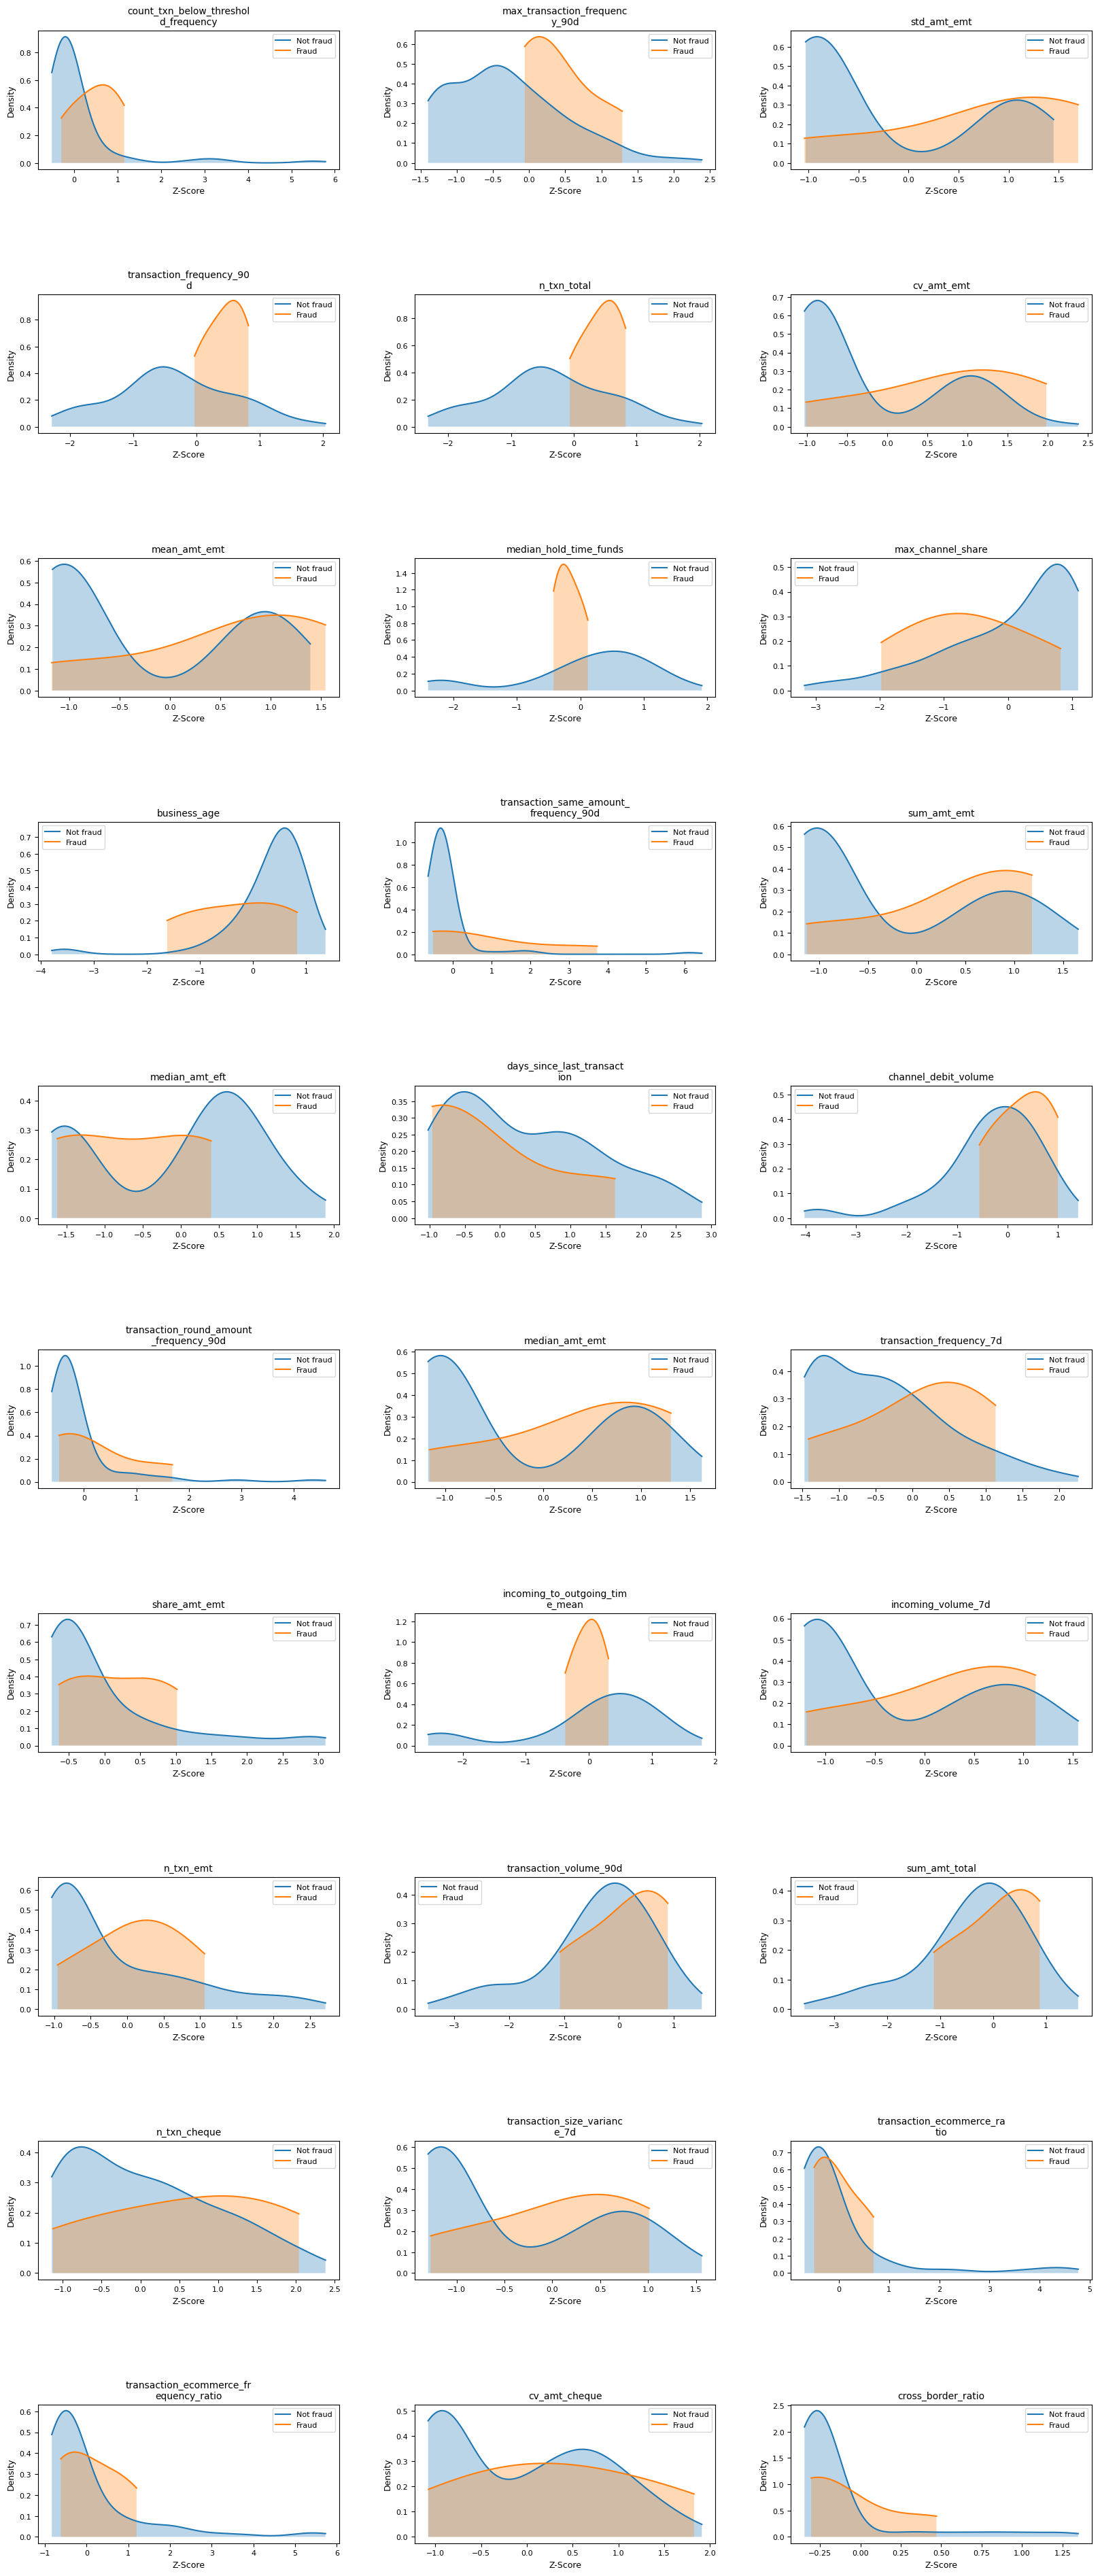

In [ ]:
import math
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import textwrap

print("###### For Buisness ######")
features = buisness_features
df = buisness_df_labeled

cols_per_row = 3
n_features = len(features)
n_rows = math.ceil(n_features / cols_per_row)

fig, axes = plt.subplots(
    n_rows,
    cols_per_row,
    figsize=(20, 4.8 * n_rows)   
)
axes = np.array(axes).reshape(-1)

def shaded_kde(ax, data, label, alpha=0.30):
    data = pd.Series(data).dropna()
    if len(data) < 2:
        return
    
    # Handle single-value case
    if data.nunique() == 1:
        single_value = data.iloc[0]
        # Plot a vertical line at the single value
        x = (single_value, single_value)
        y = (0, 1)
        ax.plot(x, y, label=label)
    # KDE
    else:
        kde = gaussian_kde(data.to_numpy())
        xmin, xmax = data.min(), data.max()
        pad = 0.05 * (xmax - xmin) if xmax > xmin else 1.0
        x = np.linspace(xmin - pad, xmax + pad, 300)
        y = kde(x)
        ax.plot(x, y, label=label)
        ax.fill_between(x, 0, y, alpha=alpha)

for i, col in enumerate(features):
    ax = axes[i]

    fraud = df.loc[df["label_y"] == 1, col]
    not_fraud = df.loc[df["label_y"] == 0, col]

    shaded_kde(ax, not_fraud, "Not fraud")
    shaded_kde(ax, fraud, "Fraud")

    
    ax.set_title("\n".join(textwrap.wrap(col, 24)), fontsize=10)

    ax.set_xlabel("Z-Score", fontsize=9)
    ax.set_ylabel("Density", fontsize=9)

    ax.tick_params(axis="both", labelsize=8)
    ax.legend(fontsize=8)


for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()


plt.subplots_adjust(
    hspace=0.9,   
    wspace=0.25   
)

plt.show()


##### For Individual #####


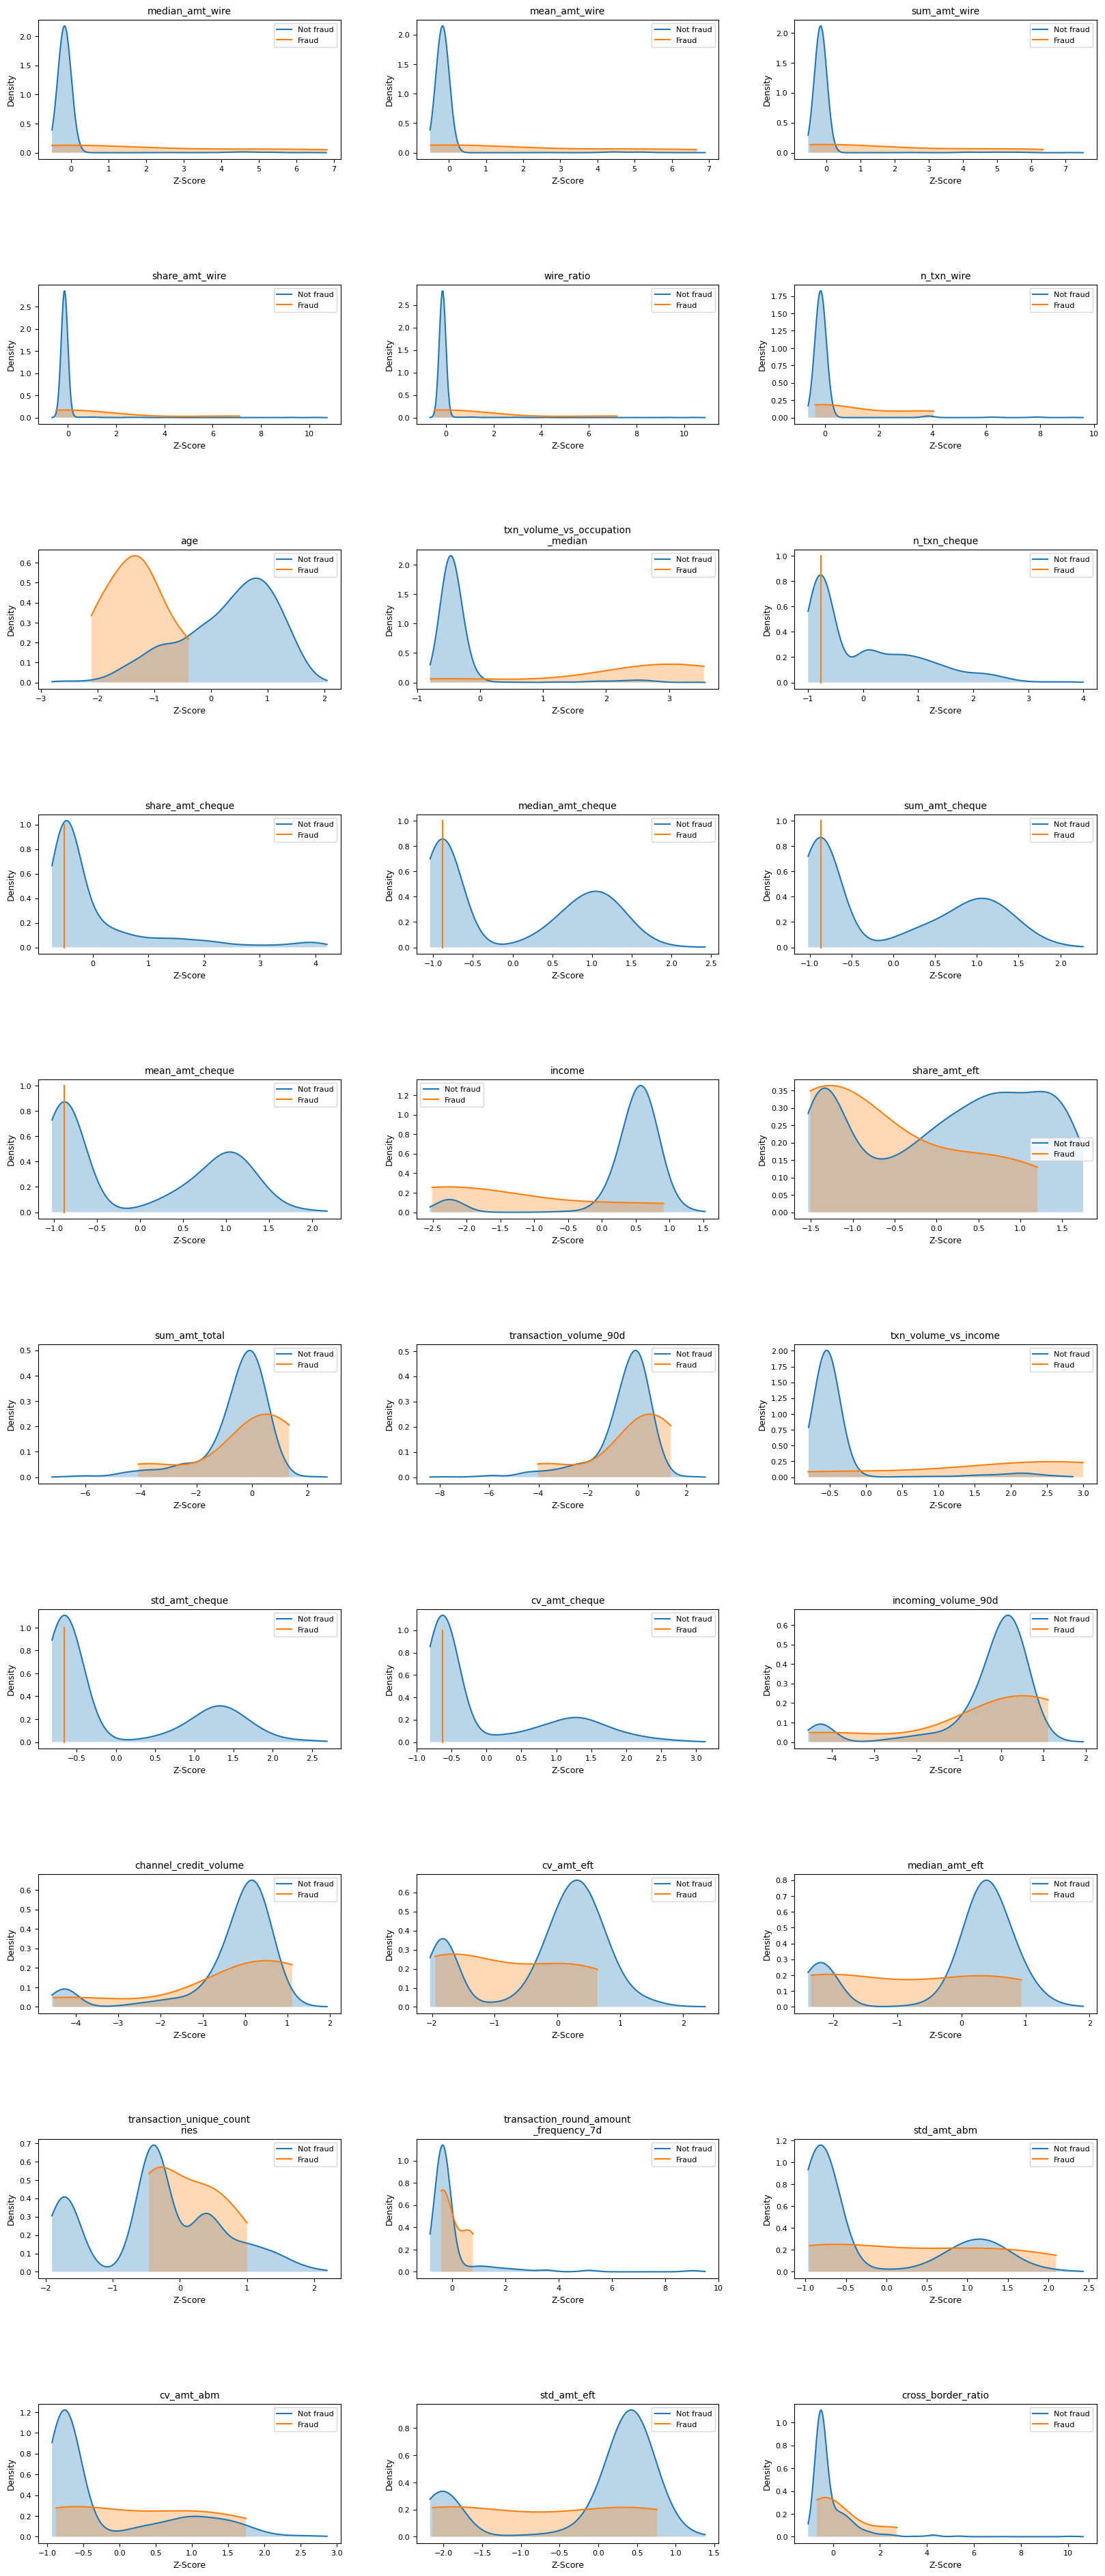

In [ ]:
print("##### For Individual #####")
features = individual_features
df = individual_df_labeled

cols_per_row = 3
n_features = len(features)
n_rows = math.ceil(n_features / cols_per_row)

fig, axes = plt.subplots(
    n_rows,
    cols_per_row,
    figsize=(20, 4.8 * n_rows)   
)
axes = np.array(axes).reshape(-1)

def shaded_kde(ax, data, label, alpha=0.30):
    data = pd.Series(data).dropna()
    if len(data) < 2:
        return

    # Handle single-value case
    if data.nunique() == 1:
        single_value = data.iloc[0]
        # Plot a vertical line at the single value
        x = (single_value, single_value)
        y = (0, 1)
        ax.plot(x, y, label=label)
    # KDE
    else:
        kde = gaussian_kde(data.to_numpy())
        xmin, xmax = data.min(), data.max()
        pad = 0.05 * (xmax - xmin) if xmax > xmin else 1.0
        x = np.linspace(xmin - pad, xmax + pad, 300)
        y = kde(x)
        ax.plot(x, y, label=label)
        ax.fill_between(x, 0, y, alpha=alpha)

for i, col in enumerate(features):
    ax = axes[i]

    fraud = df.loc[df["label_y"] == 1, col]
    not_fraud = df.loc[df["label_y"] == 0, col]

    shaded_kde(ax, not_fraud, "Not fraud")
    shaded_kde(ax, fraud, "Fraud")

    
    ax.set_title("\n".join(textwrap.wrap(col, 24)), fontsize=10)

    ax.set_xlabel("Z-Score", fontsize=9)
    ax.set_ylabel("Density", fontsize=9)

    ax.tick_params(axis="both", labelsize=8)
    ax.legend(fontsize=8)

# turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

# EXTRA spacing between rows & columns
plt.subplots_adjust(
    hspace=0.9,   
    wspace=0.25   
)

plt.show()

Categorical features

In [7]:
#### Get categorical columns #### 

categorical_columns_buis = buisness_df.select_dtypes(include="object").columns
categorical_columns_ind = individual_df.select_dtypes(include="object").columns

In [8]:
categorical_columns_buis

Index(['province', 'city', 'industry_code',
       'transaction_most_frequent_merchant',
       'transaction_most_frequent_country'],
      dtype='object')

In [9]:
categorical_columns_ind

Index(['province', 'city', 'gender', 'marital_status', 'occupation_code',
       'transaction_most_frequent_merchant',
       'transaction_most_frequent_country'],
      dtype='object')

In [35]:
buisness_encoded_df = pd.DataFrame()

# One-hot encode categorical features
X_categorical = pd.get_dummies(buisness_df[categorical_columns_buis], prefix=categorical_columns_buis, drop_first=False, dtype=int)
buisness_encoded_df = pd.concat([buisness_encoded_df, X_categorical], axis=1)

# drop rare categories
threshold = 100
categorical_columns_remove_bsn = []
for c in buisness_encoded_df.columns:
    if sum(buisness_encoded_df[c]) < threshold:
        categorical_columns_remove_bsn.append(c)

buisness_encoded_df = buisness_encoded_df.drop(columns=categorical_columns_remove_bsn)

# append binary columns
has_columns = ["has_emt", "has_eft", "has_abm", "has_wire", "has_cheque", "has_card", "has_wu", "label_y"]
buisness_encoded_df = pd.concat((buisness_encoded_df, buisness_df[has_columns]), axis=1)


In [36]:
individual_encoded_df = pd.DataFrame()

# One-hot encode categorical features
X_categorical = pd.get_dummies(individual_df[categorical_columns_ind], prefix=categorical_columns_ind, drop_first=False, dtype=int)
individual_encoded_df = pd.concat([individual_encoded_df, X_categorical], axis=1)

# drop rare categories
threshold = 100
categorical_columns_remove_ind = []
for c in individual_encoded_df.columns:
    if sum(individual_encoded_df[c]) < threshold:
        categorical_columns_remove_ind.append(c)

individual_encoded_df = individual_encoded_df.drop(columns=categorical_columns_remove_ind)

# append binary columns
has_columns = ["has_emt", "has_eft", "has_abm", "has_wire", "has_cheque", "has_card", "has_wu", "label_y"]
individual_encoded_df = pd.concat((individual_encoded_df, individual_df[has_columns]), axis=1)


In [37]:
#### Divide into labeled and unlabeled ####
buisness_encoded_df_labeled = buisness_encoded_df[buisness_encoded_df["label_y"].notna()]
buisness_encoded_df_not_labeled = buisness_encoded_df[buisness_encoded_df["label_y"].isna()]
 
individual_encoded_df_labeled = individual_encoded_df[individual_encoded_df["label_y"].notna()]
individual_encoded_df_not_labeled = individual_encoded_df[individual_encoded_df["label_y"].isna()]

print("labeled buisness data shape and df")
display(buisness_encoded_df_labeled.shape)
display(buisness_encoded_df_labeled.head())

print("unlabled buisness data shape")
display(buisness_encoded_df_not_labeled.shape)

print("Individual labeled data shape and df")
display(individual_encoded_df_labeled.shape)
display(individual_encoded_df_labeled.head())

print("Individual unlabeled data shape")
display(individual_encoded_df_not_labeled.shape)

labeled buisness data shape and df


(88, 52)

,province_AB,province_BC,province_MB,province_NS,province_ON,province_QC,city_BRAMPTON,city_CALGARY,city_EDMONTON,city_MISSISSAUGA,...,transaction_most_frequent_merchant_other,transaction_most_frequent_country_CA,has_emt,has_eft,has_abm,has_wire,has_cheque,has_card,has_wu,label_y
53145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
53248,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,1,0,0.0
53251,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0.0
53323,0,1,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,1,1,0,0.0
53868,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0


unlabled buisness data shape


(8223, 52)

Individual labeled data shape and df


(912, 186)

,province_AB,province_BC,province_MB,province_NB,province_NL,province_NS,province_ON,province_QC,province_SK,city_AIRDRIE,...,transaction_most_frequent_merchant_other,transaction_most_frequent_country_CA,has_emt,has_eft,has_abm,has_wire,has_cheque,has_card,has_wu,label_y
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,1,0,0,1,0,0.0
103,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0.0
164,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
274,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0.0
280,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0.0


Individual unlabeled data shape


(52187, 186)

In [ ]:
from sklearn.feature_selection import chi2

# Calculate chi2
X = buisness_encoded_df_labeled.iloc[:,:-1]
y = buisness_encoded_df_labeled.iloc[:,-1]
chi2_scores, p_values = chi2(X, y)

results_bsn_df = pd.DataFrame({
    "column": X.columns,
    "n_fraud": sum(buisness_encoded_df_labeled['label_y']==1),
    "n_not_fraud": sum(buisness_encoded_df_labeled['label_y']==0),
    "Chi2": chi2_scores,
    "p_value": p_values
})

# sort by raw p-value
results_bsn_df = results_bsn_df.sort_values("p_value", na_position="last")

display(results_bsn_df)

,column,n_fraud,n_not_fraud,Chi2,p_value
20,industry_code_7215,4,84,4.063492,0.043820
8,city_EDMONTON,4,84,3.857143,0.049535
10,city_NORTH YORK,4,84,3.857143,0.049535
23,industry_code_7761,4,84,2.752381,0.097110
4,province_ON,4,84,2.247947,0.133792
17,city_other,4,84,1.571429,0.210000
14,city_TORONTO,4,84,1.530612,0.216021
0,province_AB,4,84,1.166667,0.280087
44,has_emt,4,84,1.082368,0.298168
33,transaction_most_frequent_merchant_0,4,84,0.523810,0.469221


In [48]:
results_bsn_df.to_csv("chi2_results_buisness.csv", index=False)

In [49]:
# Calculate chi2
X = individual_encoded_df_labeled.iloc[:,:-1]
y = individual_encoded_df_labeled.iloc[:,-1]
chi2_scores, p_values = chi2(X, y)

results_ind_df = pd.DataFrame({
    "column": X.columns,
    "n_fraud": sum(individual_encoded_df_labeled['label_y']==1),
    "n_not_fraud": sum(individual_encoded_df_labeled['label_y']==0),
    "Chi2": chi2_scores,
    "p_value": p_values
})

# sort by raw p-value
results_ind_df = results_ind_df.sort_values("p_value", na_position="last")

display(results_ind_df)

,column,n_fraud,n_not_fraud,Chi2,p_value
156,occupation_code_STUDENT,6,906,68.322881,1.388010e-16
21,city_CAMBRIDGE,6,906,36.264901,1.722381e-09
181,has_wire,6,906,25.256701,5.018490e-07
63,city_PRINCE GEORGE,6,906,23.527594,1.231350e-06
167,transaction_most_frequent_merchant_5331,6,906,23.527594,1.231350e-06
...,...,...,...,...,...
180,has_abm,6,906,0.000058,9.939320e-01
23,city_CORNWALL,6,906,NaN,NaN
25,city_DELTA,6,906,NaN,NaN
65,city_REGINA,6,906,NaN,NaN


In [50]:
results_ind_df.to_csv("chi2_results_individual.csv", index=False)

In [52]:
buisness_features = results_bsn_df['column'].iloc[:9]
individual_features = results_ind_df['column'].iloc[:9]

##### For Business #####


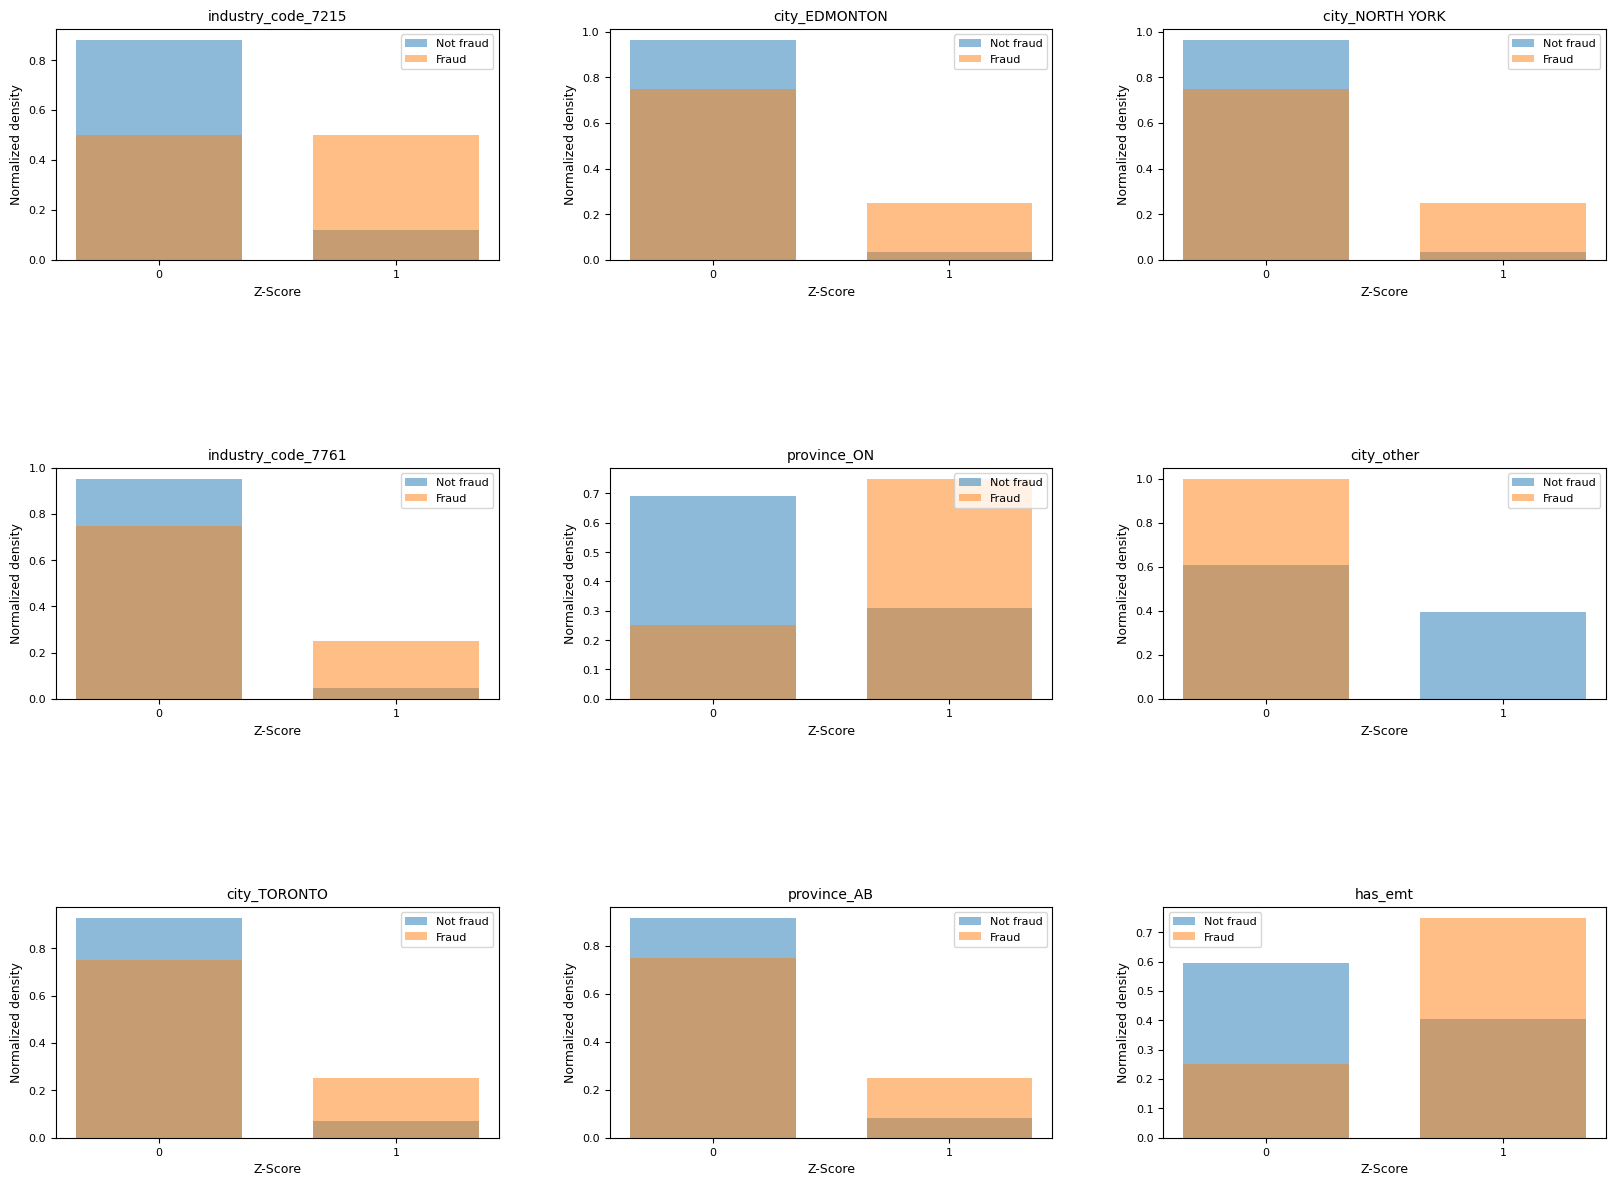

In [65]:
import math
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import textwrap

print("##### For Business #####")
features = buisness_features
df = buisness_encoded_df_labeled

cols_per_row = 3
n_features = len(features)
n_rows = math.ceil(n_features / cols_per_row)

fig, axes = plt.subplots(
    n_rows,
    cols_per_row,
    figsize=(20, 4.8 * n_rows)   
)
axes = np.array(axes).reshape(-1)

def histogram(ax, data, label, alpha=0.5):
    data = pd.Series(data).dropna()
    ax.hist(data, bins=[-0.5, 0.5, 1.5], density=True, rwidth=0.7, alpha=alpha, label=label)
    ax.set_xticks([0, 1])

for i, col in enumerate(features):
    ax = axes[i]

    fraud = df.loc[df["label_y"] == 1, col]
    not_fraud = df.loc[df["label_y"] == 0, col]

    histogram(ax, not_fraud, "Not fraud")
    histogram(ax, fraud, "Fraud")

    
    ax.set_title("\n".join(textwrap.wrap(col, 24)), fontsize=10)

    ax.set_xlabel("Z-Score", fontsize=9)
    ax.set_ylabel("Normalized density", fontsize=9)

    ax.tick_params(axis="both", labelsize=8)
    ax.legend(fontsize=8)


for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()


plt.subplots_adjust(
    hspace=0.9,   
    wspace=0.25   
)

plt.show()

##### For Individuals #####


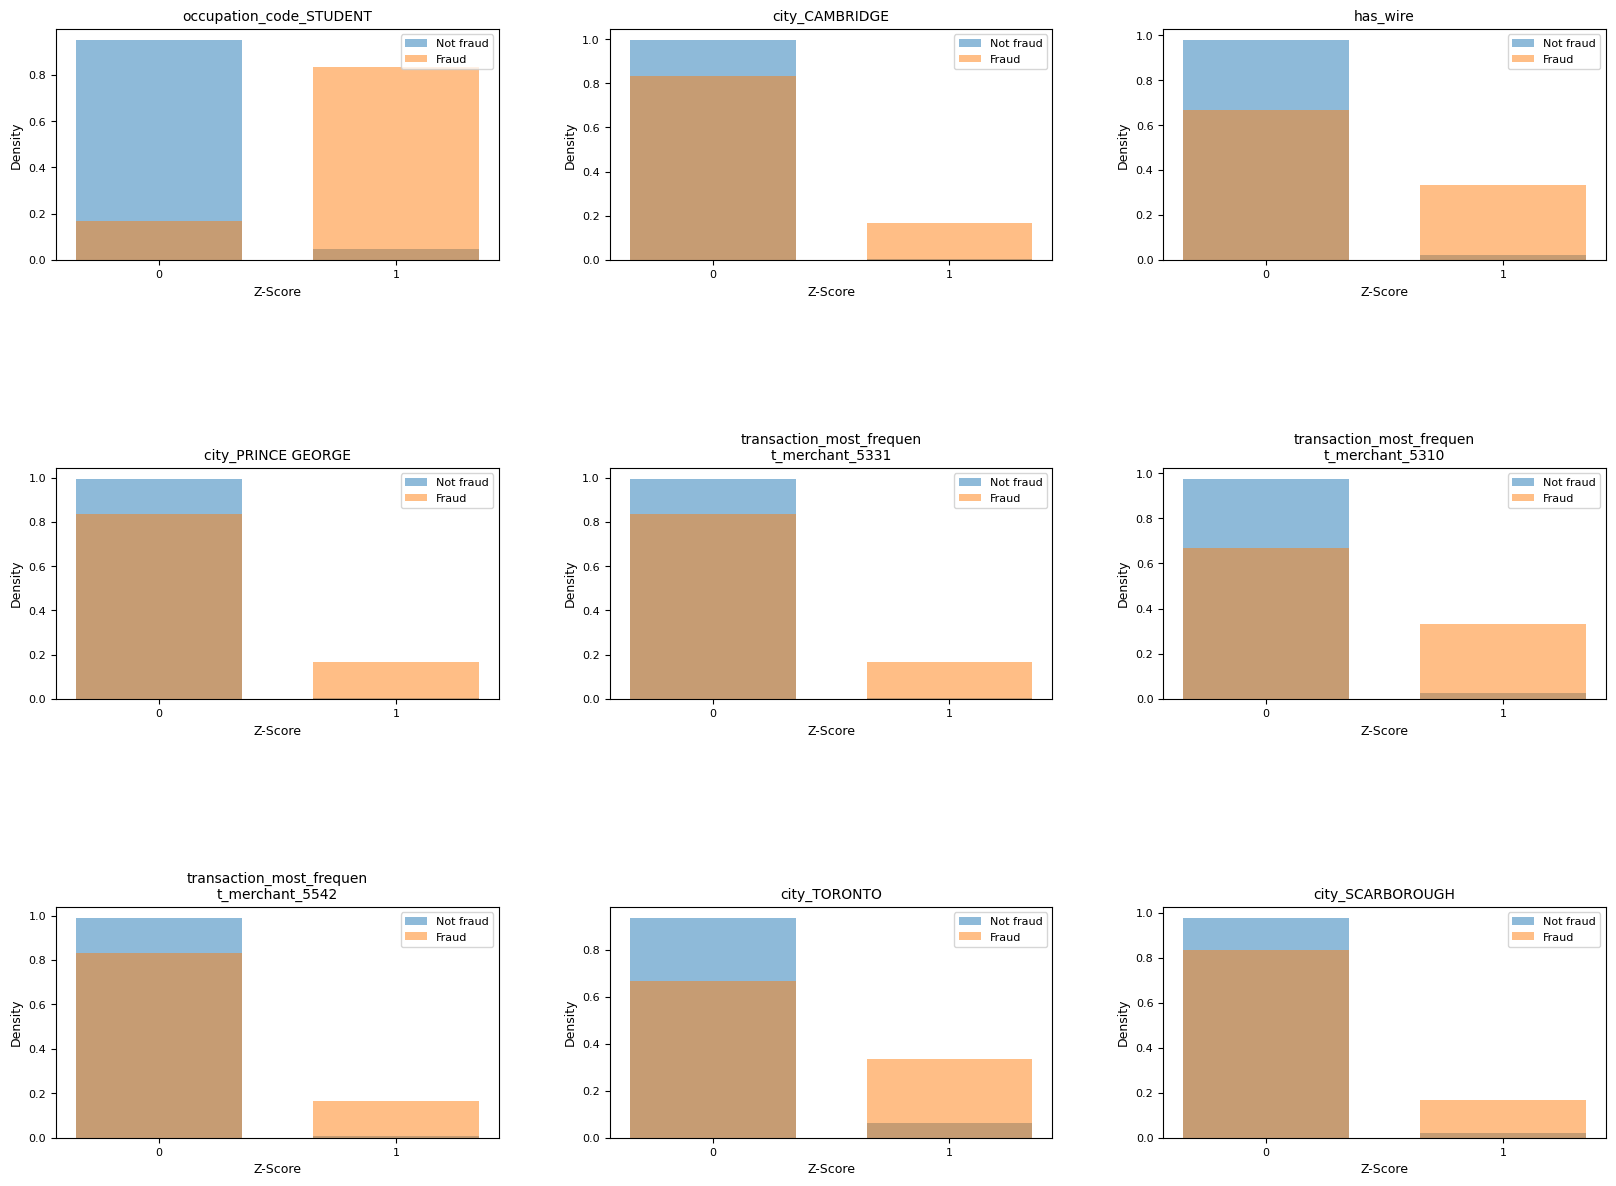

In [66]:
print("##### For Individuals #####")
features = individual_features
df = individual_encoded_df_labeled

cols_per_row = 3
n_features = len(features)
n_rows = math.ceil(n_features / cols_per_row)

fig, axes = plt.subplots(
    n_rows,
    cols_per_row,
    figsize=(20, 4.8 * n_rows)   
)
axes = np.array(axes).reshape(-1)

def histogram(ax, data, label, alpha=0.5):
    data = pd.Series(data).dropna()
    ax.hist(data, bins=[-0.5, 0.5, 1.5], density=True, rwidth=0.7, alpha=alpha, label=label)
    ax.set_xticks([0, 1])
    ax.set_ylabel('Normalized density')

for i, col in enumerate(features):
    ax = axes[i]

    fraud = df.loc[df["label_y"] == 1, col]
    not_fraud = df.loc[df["label_y"] == 0, col]

    histogram(ax, not_fraud, "Not fraud")
    histogram(ax, fraud, "Fraud")

    
    ax.set_title("\n".join(textwrap.wrap(col, 24)), fontsize=10)

    ax.set_xlabel("Z-Score", fontsize=9)
    ax.set_ylabel("Density", fontsize=9)

    ax.tick_params(axis="both", labelsize=8)
    ax.legend(fontsize=8)


for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()


plt.subplots_adjust(
    hspace=0.9,   
    wspace=0.25   
)

plt.show()